
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, xds_reindex_daily

from teslakit.plotting.climate_emulator import Plot_Simulation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')



## Historical Data: prepare hourly format

In [3]:
# Generate historical complete hourly data and store it as xarray.Dataset
HIST_COMPLETE = db.Generate_HIST_Complete()
db.Save_HIST_Complete_hourly(HIST_COMPLETE)

# store also a daily version
HIST_COMPLETE_d = xds_reindex_daily(HIST_COMPLETE)
db.Save_HIST_Complete_daily(HIST_COMPLETE_d)

print(HIST_COMPLETE)


<xarray.Dataset>
Dimensions:  (time: 157801)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-16 1996-01-16T01:00:00 ... 2014-01-16
Data variables:
    AWT      (time) int64 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    MJO      (time) int64 17 17 17 17 17 17 17 17 17 ... 21 21 21 21 21 21 21 21
    DWT      (time) int64 5 5 5 5 5 5 5 5 5 5 ... 31 31 31 31 31 31 31 31 31 31
    MMSL     (time) float64 -0.04931 -0.04931 -0.04931 ... -0.03645 -0.04574
    AT       (time) float64 1.001 1.026 0.961 0.82 ... 0.057 -0.076 -0.047 0.147
    Hs       (time) float64 2.548 2.548 2.548 2.592 ... 2.61 2.61 2.61 2.588
    Tp       (time) float64 13.85 13.85 13.85 13.52 ... 8.18 8.18 8.18 8.197
    Dir      (time) float64 6.048 6.048 6.048 0.6748 ... 50.16 50.16 50.16 50.47
Attributes:
    source:   teslakit_v0.9.1



## Simulated Waves: prepare MaxStorm and hourly formats

In [4]:
# --------------------------------------
# aux. functions

def waves_hourly(CE, n_sims_DWTs, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - join DWTs-WVs Climate emulator simulations for all n_sims_DWTs
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''

    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n)    
        WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  # (one CE sim. for each DWT sim.)
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)

        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(WVS_upd)

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy


In [5]:
# --------------------------------------
# Climate Emulator extremes model output

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
n_sims_DWTs = 10


# Generate all MaxStorm DWTs-WVS-TCS simulations as a pandas.Dataframe (adding time and n_sim as columns)
WVS_sim = CE.LoadSim_All()
db.Save_CE_AllSims(WVS_sim)


# Generate hourly waves xarray.Dataset using intradaily hydrographs
WVS_sim_h = waves_hourly(CE, n_sims_DWTs)  
db.Save_SIM_Waves_hourly(WVS_sim_h)

print(WVS_sim_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 0.6322 0.6595 0.6867 ... 0.742 0.718 0.6941
    Tp       (n_sim, time) float32 11.57887 11.57887 ... 7.550725 10.31731
    Dir      (n_sim, time) float32 62.093018 62.093018 ... 48.96019 344.08667
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.3956 0.404 0.4123 ... 0.2795 0.2749 0.3693
Attributes:
    source:   teslakit_v0.9.1



## Complete Simulation: load covariates and merge with hourly waves

In [6]:
# --------------------------------------
# Covariates: AWTs, DWTs, MJO, MMSL, AT

# Generate hourly covariates data
CVS_sim_h = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)
db.Save_SIM_Covariates_hourly(CVS_sim_h)


# --------------------------------------
# Complete simulation output 
d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

# merge all data
SIM_COMPLETE = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL
SIM_COMPLETE['TWL'] = SIM_COMPLETE['AWL'] + SIM_COMPLETE['SS'] + SIM_COMPLETE['AT'] + SIM_COMPLETE['MMSL']
db.Save_SIM_Complete_hourly(SIM_COMPLETE)

print(SIM_COMPLETE)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 0.6322 0.6595 0.6867 ... 0.766 0.742 0.718
    Tp       (n_sim, time) float32 11.57887 11.57887 ... 7.550725 7.550725
    Dir      (n_sim, time) float32 62.093018 62.093018 ... 48.96019 48.96019
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.3956 0.404 0.4123 ... 0.2839 0.2795 0.2749
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 27 27 27 ... 16 16 16 16 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.307724 ... 0.57611704 0.38318345
    TWL      (n_sim, time) float64 

In [7]:
# reindex complete simulation to daily and store it
SIM_COMPLETE_d = xds_reindex_daily(SIM_COMPLETE)
db.Save_SIM_Complete_daily(SIM_COMPLETE_d)

print(SIM_COMPLETE_d)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 365243)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-02 ... 2999-12-30 2999-12-31
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 0.6322 1.286 1.94 ... 0.6941 1.845 1.269
    Tp       (n_sim, time) float32 11.57887 11.57887 ... 7.550725 7.550725
    Dir      (n_sim, time) float32 62.093018 62.093018 ... 48.96019 48.96019
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.3956 0.5642 0.6929 ... 0.2703 0.4406 0.3655
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 15 23 23 25 25 25 ... 18 19 19 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 21 26 26 ... 34 34 34 20 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.2233721 ... 0.41754416 0.34369332
    TWL      (n_sim, ti

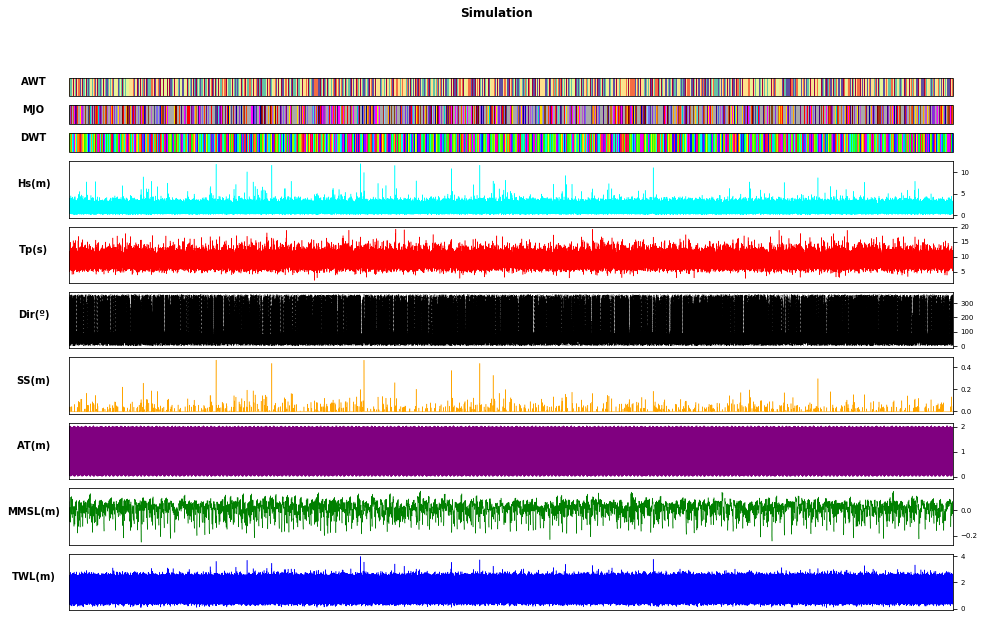

In [8]:
# Plot Simulation 

Plot_Simulation(SIM_COMPLETE.sel(n_sim=0));
